# Variogram estimation

This notebook is used to implement your own variogram estimation algorithm.


In [ ]:
!pip install scikit-gstat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Load data

This chapter loads the data and transforms it into a CRS using meter as unit

In [ ]:
from pathlib import Path

PATH = Path('/content/drive/MyDrive/Geostatistics/content/data')

In [ ]:
import pandas as pd

data = pd.read_csv(PATH / 'precipitation_sums_2023-10-01.csv')
data

In [ ]:
import pyproj

# create a transform and apply
src = pyproj.CRS.from_epsg(4326)
tgt = pyproj.CRS.from_epsg(25832)
transform = pyproj.Transformer.from_crs(src, tgt, always_xy=True)
tuples = transform.transform(data.longitude.values, data.latitude.values)

# create the coordinates and values list
coordinates = list(zip(*tuples))
values = data.value.values.tolist()

## Calculate the lag classes and groups

You could also use your solution from the last exercise (Pairs.ipynb).
Here, we simply use scikit-gstat to do that step for us.

In [ ]:
import skgstat as skg

vario = skg.Variogram(coordinates, values, n_lags=50, maxlag=500_000, use_nugget=True)
fig = vario.distance_difference_plot()

## Task 6.1

We reuse the code from the last exercise to make our live a bit easier.


In [ ]:
import numpy as np

def matheron(obs_pairs) -> float:
  x = np.asarray(obs_pairs)
  if x.size == 0:
    return np.nan
  return np.sum(x**2) / (2 * x.size)

def cressie(obs_pairs) -> float:
  x = np.asarray(obs_pairs)
  if x.size == 0:
    return np.nan

  nominator = ((1 / x.size) * np.sum(np.power(x, 0.5)))**4
  denominator = 2 * (0.457 + (0.494 / x.size) + (0.045 / x.size**2))

  return nominator / denominator


In [ ]:
# here we create a random sample and test our function against the skgstat estimator
np.random.seed(42)

pairs = np.random.normal(10, 2, size=400)

# test
assert skg.estimators.matheron(pairs) - matheron(pairs) < 0.01
assert skg.estimators.cressie(pairs) - cressie(pairs) < 0.01

## Task 6.2


In [ ]:
# create a container for matheron and cressie semi-variance
experimental_matheron = []
experimental_cressie = []

# the number of lags is also accessible
for class_index in range(vario.n_lags):
  # get all differences at the current group index
  pairs = vario._diff[vario.lag_groups() == class_index]

  # calculate the semi-variance
  experimental_matheron.append(matheron(pairs))
  experimental_cressie.append(cressie(pairs))

In [ ]:
# we can test this as well
from numpy.testing import assert_array_almost_equal

assert_array_almost_equal(vario.experimental, experimental_matheron)

In [ ]:
# and plot it
import matplotlib.pyplot as plt

plt.plot(vario.bins, experimental_matheron, '.b', label='Matheron')
plt.plot(vario.bins, experimental_cressie, '.r', label='Cressie-Hawkins')
plt.legend()

## 7.1 Theoretical variogram models

Implement the spherical, exponential and gaussian model in a way, that you can parameterize them using the **effective** range, not the range parameter

In [ ]:
from math import e, pow

def spherical(h, a, C, C0=0.0) -> float:
  return 42


def exponential(h, a, C, C0=0.0) -> float:
  return 42

def gaussian(h, a, C, C0=0.0) -> float:
  return 42


In [ ]:
# test our implementation to SciKit-GStat
from skgstat import models

# spherical
print('Spherical:')
print(f"{models.spherical(200, 150, 5, 0.0)} == {spherical(200, 150, 5, 0.0)}")
print(f"{models.spherical(80, 150, 5, 0.0)} == {spherical(80, 150, 5, 0.0)}")
print(f"{models.spherical(75, 150, 7, 3.0)} == {spherical(75, 150, 7, 3.0)}\n")

# exponential
print('Exponential:')
print(f"{models.exponential(200, 150, 5, 0.0)} == {exponential(200, 150, 5, 0.0)}")
print(f"{models.exponential(80, 150, 5, 0.0)} == {exponential(80, 150, 5, 0.0)}")
print(f"{models.exponential(75, 150, 7, 3.0)} == {exponential(75, 150, 7, 3.0)}\n")

# gaussian
# exponential
print('Gaussian:')
print(f"{models.gaussian(200, 150, 5, 0.0)} == {gaussian(200, 150, 5, 0.0)}")
print(f"{models.gaussian(80, 150, 5, 0.0)} == {gaussian(80, 150, 5, 0.0)}")
print(f"{models.gaussian(75, 150, 7, 3.0)} == {gaussian(75, 150, 7, 3.0)}")

## 7.3 Fitting a variogram model

For this task, we will estimate the variogram model parameters manually and parameterize the model function. use the cell below to change the parameters:

In [ ]:
# change these parameters here:
NUGGET = 600
EFF_RANGE = 200_000
SILL = 1000

# specify the model
MODEL = spherical

# discreticise the function at 100 step from 0 up to the maximum lag distance
x = np.linspace(0, vario.maxlag, 100)

# parameterize the model - it should only take one parameter -> the dependent variable
par_model = lambda h: MODEL(h, EFF_RANGE, SILL, NUGGET)

# map the model on the input data
y = list(map(par_model, x))

# plot
plt.plot(vario.bins, experimental_matheron, '.b')
plt.plot(x, y, '-g')

## Task 7.4 Evaluate the model

We evalualte the model from above at the bins and calculate the RMSE to the observations


In [ ]:
# predict the semi-variance at the bins
pred =

# RMSE
rmse =

## Task 7.5 Brute-Force fitting

In this task we apply brute-force fitting. That means, we define a parameter space, discretize it and test **all** paramter combinations. For this Task, we will fix the nugget to 400.

In [ ]:
from tqdm import tqdm
from itertools import product

# here you can change the model
model = gaussian

# here you could change the objective function
loss = lambda x, y: np.sqrt(np.mean((y - x)**2))

ranges = np.linspace(350_000, 500_000, 100)
sills = np.linspace(1400, 2000, 100)
C0 = 400


# result container
losses = []


# now test every single combination
for r, C in tqdm(product(ranges, sills), total=len(ranges) * len(sills)):
  # parameterize the model
  par_model =


  # map the parameterized model on the bins
  pred =

  # calculate the loss
  err =

  losses.append(err)

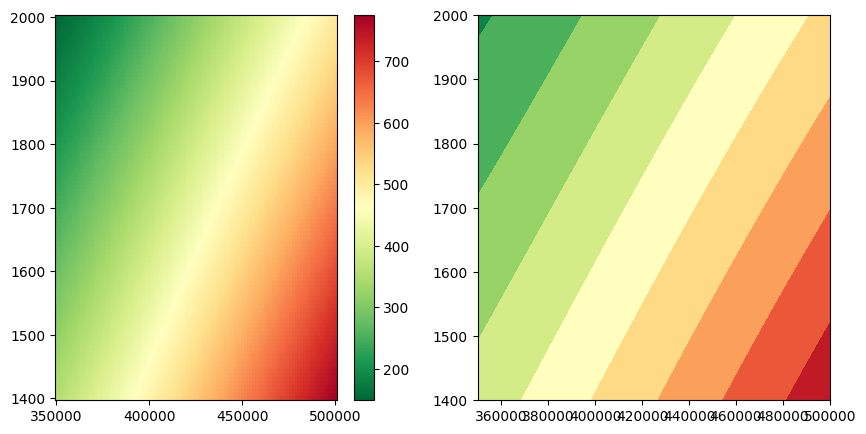

In [ ]:
# finally create the plot
fig, axes = plt.subplots(1, 2, figsize=(10,5))
m = axes[0].pcolormesh(ranges, sills, np.asarray(losses).reshape(100,100), cmap='RdYlGn_r')
axes[1].contourf(ranges, sills, np.asarray(losses).reshape(100,100), cmap='RdYlGn_r')
plt.colorbar(m)